<a href="https://colab.research.google.com/github/Aditya-1794/Malaria-Detection-Research-Paper/blob/main/Horizon_Code_Malaria_95_100_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [ ]:
! pip install -q opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/sayeemmohammed/malaria-detection')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: adityajha719
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/sayeemmohammed/malaria-detection


100%|██████████| 62.8M/62.8M [00:03<00:00, 17.1MB/s]


In [ ]:
#delete the malaria-detection directory
import os
import shutil
shutil.rmtree('/content/malaria-detection')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras==3.3.3

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from PIL import Image
import shutil

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2, Xception, EfficientNetB0
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


# Preprocessing and Image augmentation

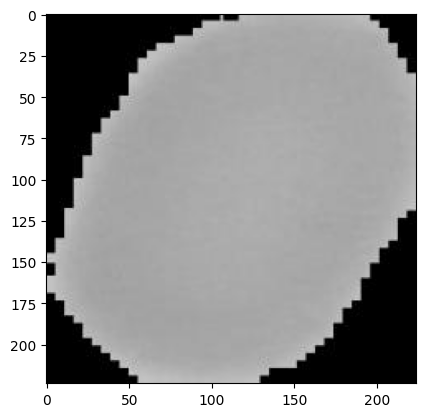

In [ ]:
#sample path:
#/content/malaria-detection/test/Uninfected/C58P19thinF_IMG_20150802_121847_cell_44_png.rf.668a45b95241a917101680fea7c1c935.jpg
plt.imshow(Image.open('/content/malaria-detection/test/Uninfected/C58P19thinF_IMG_20150802_121847_cell_44_png.rf.668a45b95241a917101680fea7c1c935.jpg'))

In [ ]:
#Working with images
count = 0
train_images = []

# Walk through the directory and get filenames
for dirname, _, filenames in os.walk('/content/malaria-detection/train/Parasitized'):
    # Sort the filenames
    filenames.sort()
    for filename in filenames:
        train_images.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/malaria-detection/train/Uninfected'):
    # Sort the filenames
    filenames.sort()
    for filename in filenames:
        train_images.append(os.path.join(dirname, filename))

#add tricky images to a dictionary
trickyImages = {}
classes = ['Parasitized', 'Uninfected']
for i in range(len(train_images)):
  if i in errors:
    if 'Parasitized' in train_images[i]:
      trickyImages[train_images[i]] = classes[0]
    else:
      trickyImages[train_images[i]] = classes[1]


#They key is the image path and the value is the actual value (prediction is opposite of that)
print(list(trickyImages.keys())[0])
print(len(list(trickyImages.keys())))

/content/malaria-detection/train/Parasitized/C100P61ThinF_IMG_20150918_145938_cell_171_png.rf.9b7d9c6a83572effbbf27bfde81306ab_aug0.jpg
545


In [ ]:
#TEST SET
count = 0
test_images = []

# Walk through the directory and get filenames
for dirname, _, filenames in os.walk('/content/malaria-detection/test/Parasitized'):
    # Sort the filenames
    filenames.sort()
    for filename in filenames:
        test_images.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/malaria-detection/test/Uninfected'):
    # Sort the filenames
    filenames.sort()
    for filename in filenames:
        test_images.append(os.path.join(dirname, filename))

#add tricky images to a dictionary
trickyImages_test = {}
classes = ['Parasitized', 'Uninfected']
for i in range(len(test_images)):
  if i in errors1:
    if 'Parasitized' in test_images[i]:
      trickyImages_test[test_images[i]] = classes[0]
    else:
      trickyImages_test[test_images[i]] = classes[1]


#They key is the image path and the value is the actual value (prediction is opposite of that)
print(list(trickyImages_test.keys())[0])
print(len(list(trickyImages_test.keys())))

/content/malaria-detection/test/Parasitized/C109P70ThinF_IMG_20150930_103645_cell_174_png.rf.5d3fb983b39e32d41405e120fc01ca34.jpg
32


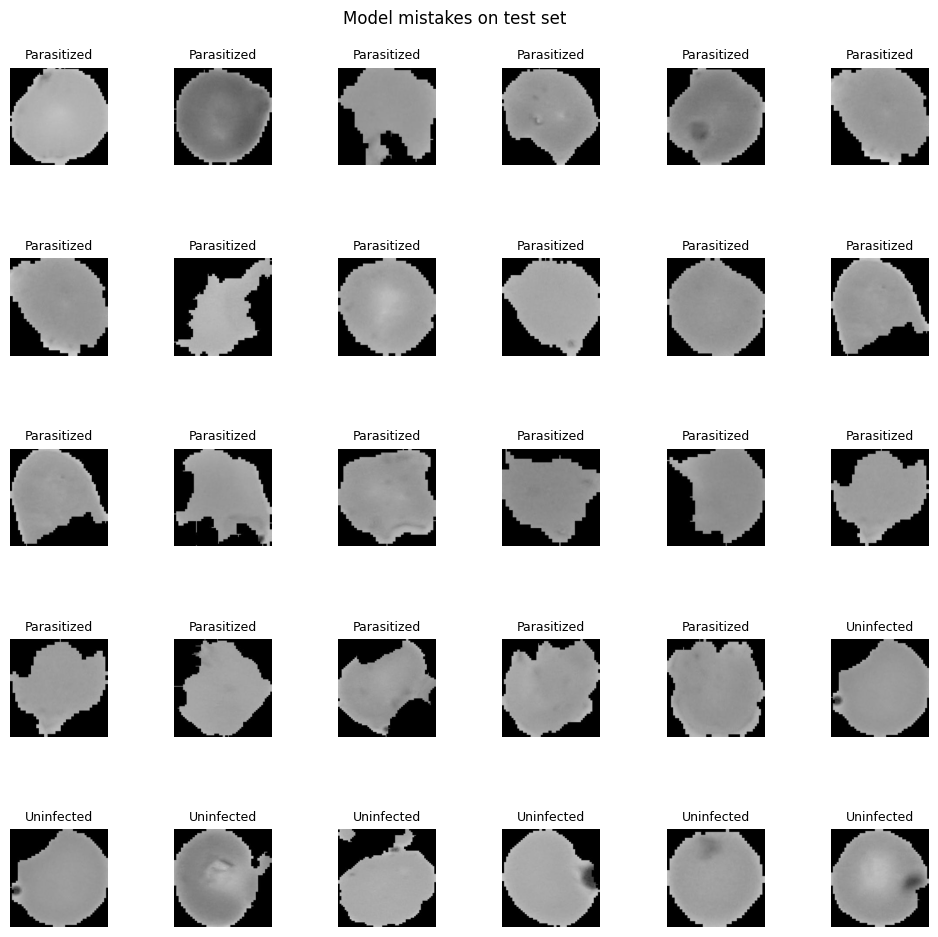

In [ ]:
#TEST SET
#visualize images
keys = list(trickyImages_test.keys())
len(keys)

#plot all in a matplotlib grid
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(10, 10))
fig.suptitle("Model mistakes on test set")
# remove the extra space between the rows
#fig.subplots_adjust(hspace=5.0)
fig.tight_layout()
for i in range(5):
  for j in range(6):
    ax[i, j].imshow(Image.open(keys[(i*5+j)]))
    ax[i, j].axis('off')
    ax[i, j].set_title(trickyImages_test[keys[(i*5+j)]], fontsize=9)

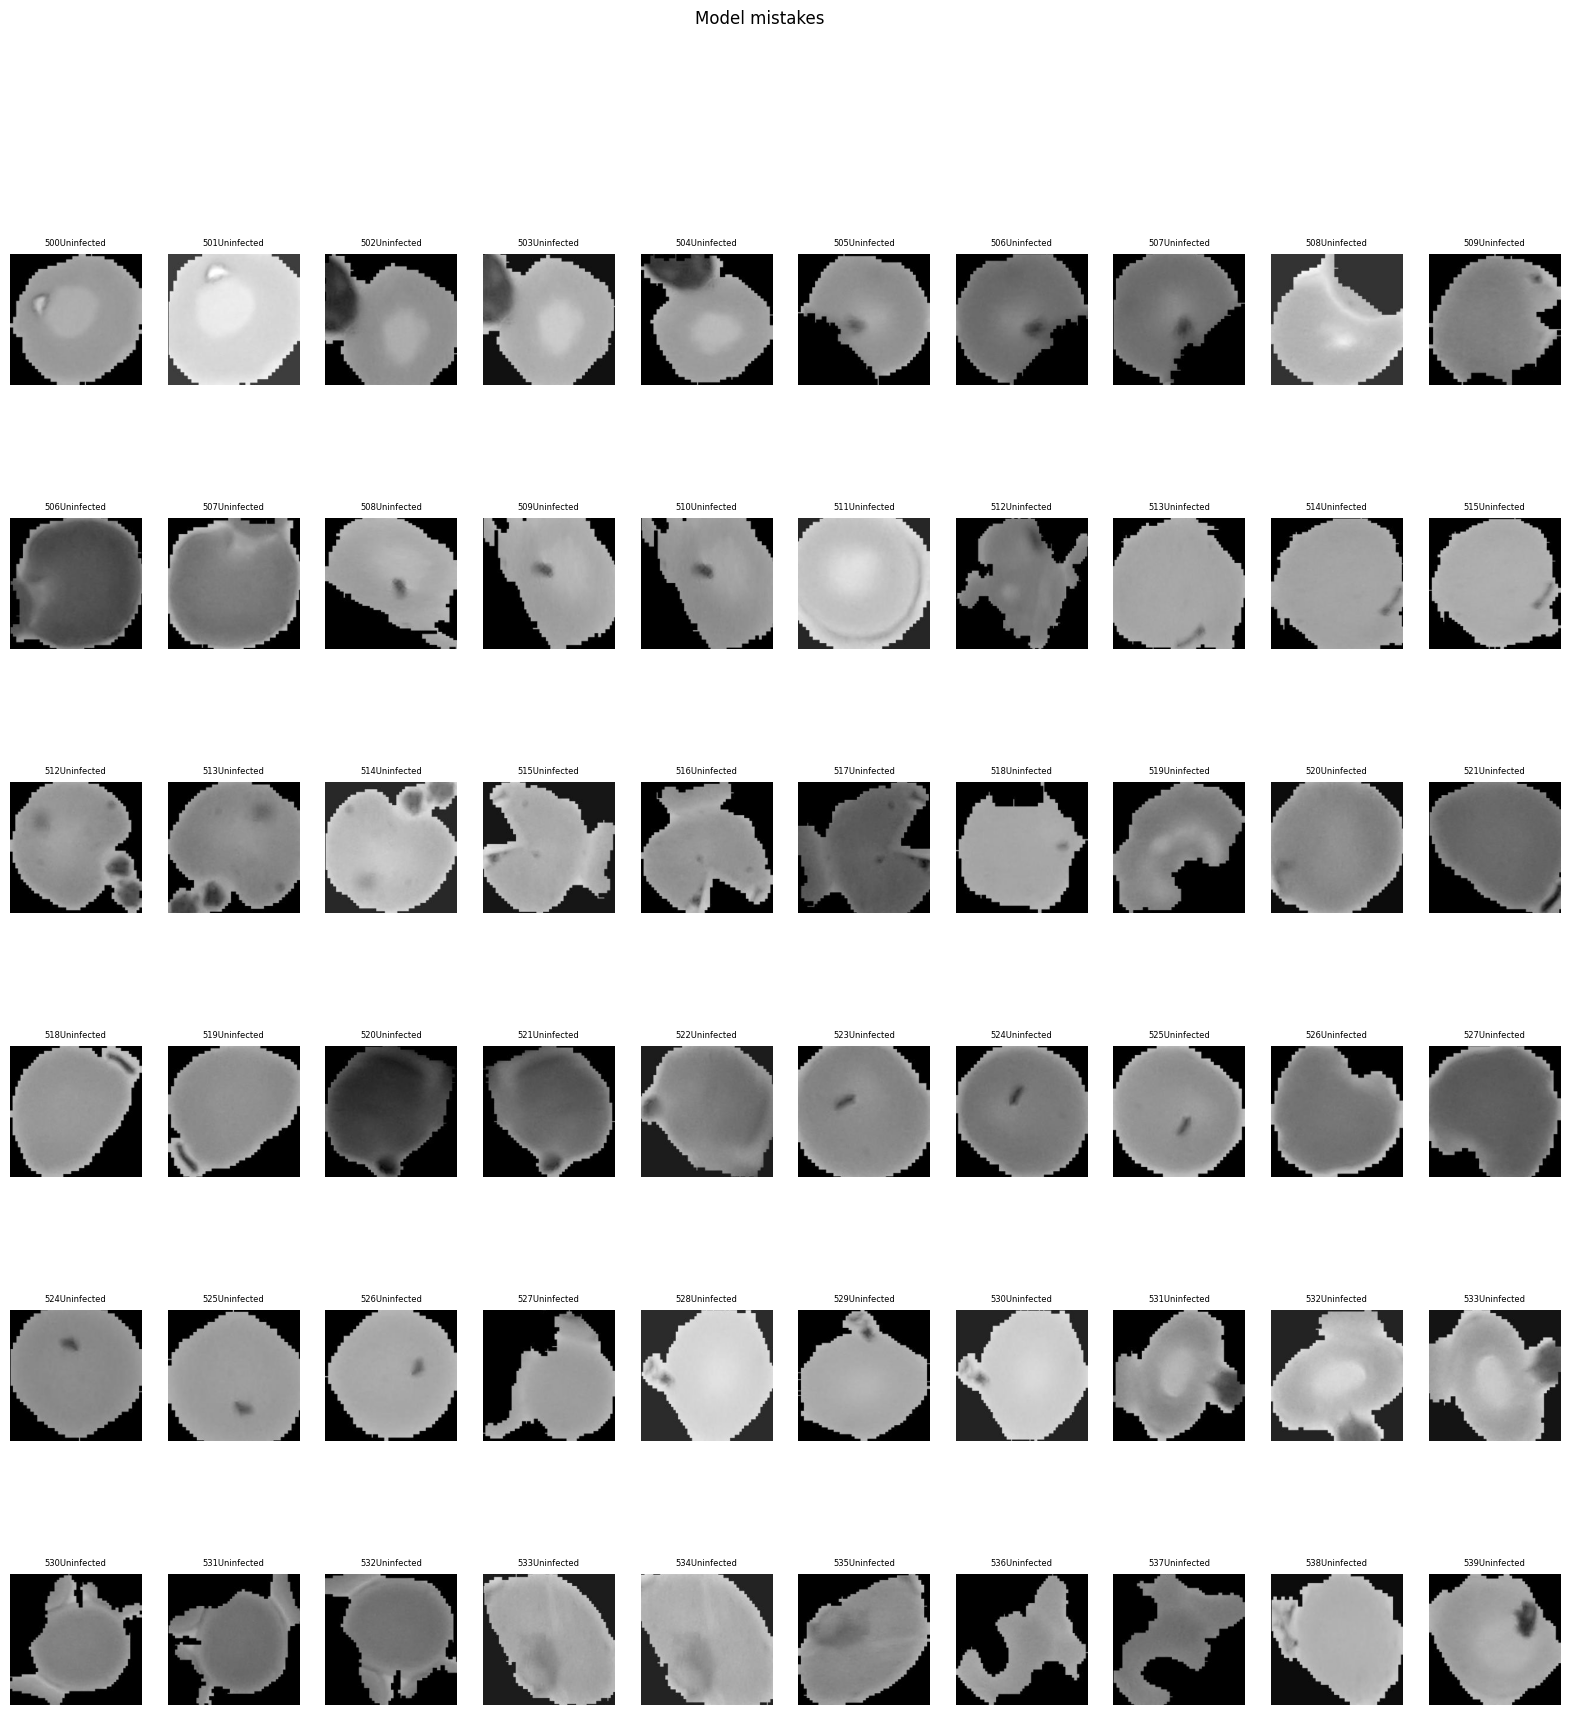

In [ ]:
#visualize images
keys = list(trickyImages.keys())
len(keys)

#plot all in a matplotlib grid
fig, ax = plt.subplots(nrows=6, ncols=10, figsize=(20, 20))
fig.suptitle("Model mistakes")
for i in range(6):
  for j in range(10):
    ax[i, j].imshow(Image.open(keys[500 + (i*10+j)]))
    ax[i, j].axis('off')
    ax[i, j].set_title(str(500 + (i*6+j)) + trickyImages[keys[500 + (i*6+j)]], fontsize=6)

In [ ]:
superTrickyImages = {}

firstHundred = [0, 1, 2, 3, 10, 11, 12, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 31, 32, 33, 34, 41, 44, 63, 64, 65, 66, 67, 71, 72, 73, 74, 78, 81, 82, 83, 84, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
secondHundred = [100, 101, 103, 104, 115, 116, 119, 120, 126, 135, 136, 137, 138, 144, 145, 146, 148, 149, 169, 170, 174, 191, 193, 194, 195]
thirdHundred = [214, 215, 228, 229, 330, 233, 270, 271, 272, 292]
fourthHundred = [301, 302, 303, 314, 323, 325, 329, 336, 330, 331, 332, 336, 350, 351, 354, 363, 381, 382, 384, 385, 388, 389, 390]
fifthHundred = [466, 467, 486, 487, 489, 490, 491, 495, 496, 497, 498, 499]
remainder = [520, 521, 526, 527, 530, 531, 532, 533, 534, 535, 536, 537]

allSuperTricky = firstHundred + secondHundred + thirdHundred + fourthHundred + fifthHundred + remainder
print(len(allSuperTricky))

keys = list(trickyImages.keys())
for i in range(len(keys)):
  if i in allSuperTricky:
    if 'Parasitized' in keys[i]:
      superTrickyImages[keys[i]] = classes[0]
    elif 'Uninfected' in keys[i]:
      superTrickyImages[keys[i]] = classes[1]

print(len(superTrickyImages.keys()))

133
131


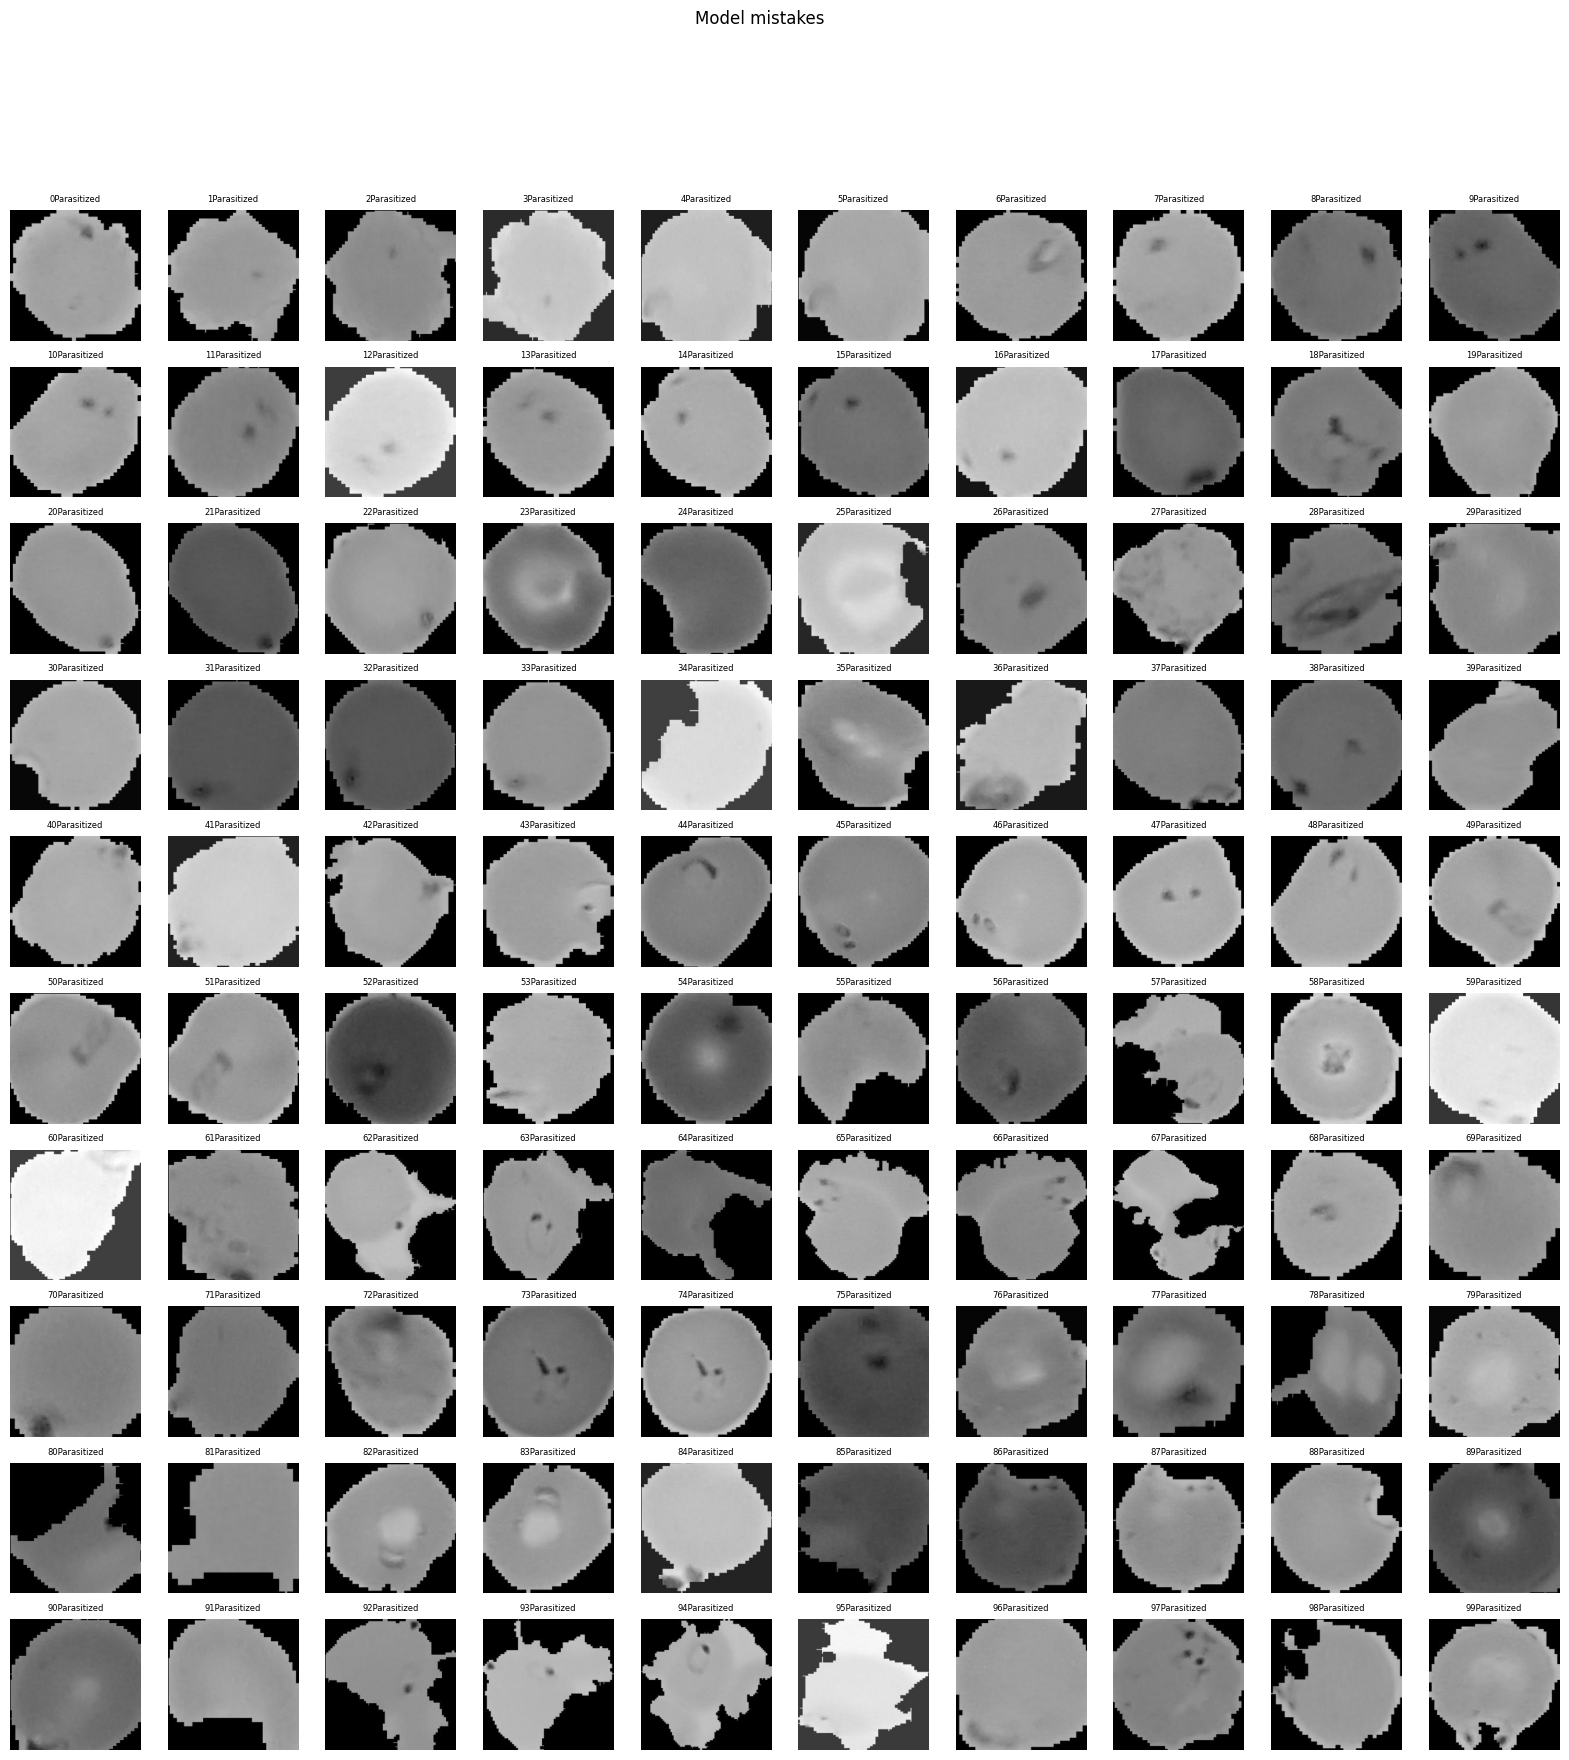

In [ ]:
#plot super tricky images
superKeys = list(superTrickyImages.keys())
len(superKeys)

#plot all in a matplotlib grid
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(20, 20))
fig.suptitle("Model mistakes")
for i in range(10):
  for j in range(10):
    ax[i, j].imshow(Image.open(superKeys[(i*10+j)]))
    ax[i, j].axis('off')
    ax[i, j].set_title(str((i*10+j)) + superTrickyImages[superKeys[(i*10+j)]], fontsize=6)

In [ ]:
#Add 6 of each image to the training set to remove class imbalance
numCopies = 1;
for image in superTrickyImages.keys():
  for i in range(numCopies):
    suffix = image.split('/')[-1]
    suffix = suffix.split('.')
    suffix = '.'.join(suffix[:-1]) + '_aug' + str(i) + '.' + suffix[-1]
    print('/content/malaria-detection/train/'+superTrickyImages[image]+'/'+str(suffix))
    shutil.copyfile(image, '/content/malaria-detection/train/'+superTrickyImages[image]+'/'+str(suffix))

print(str(numCopies) + ' copies of each super tricky image have been added to the dataset to prevent class imbalance')

/content/malaria-detection/train/Parasitized/C100P61ThinF_IMG_20150918_145938_cell_171_png.rf.9b7d9c6a83572effbbf27bfde81306ab_aug0.jpg
/content/malaria-detection/train/Parasitized/C101P62ThinF_IMG_20150923_165215_cell_22_png.rf.0300a50f3a166a5c8caa1ec7ae808356_aug0.jpg
/content/malaria-detection/train/Parasitized/C101P62ThinF_IMG_20150923_165215_cell_22_png.rf.6b9b12f23a011fb09e592910fb95f3f8_aug0.jpg
/content/malaria-detection/train/Parasitized/C101P62ThinF_IMG_20150923_165215_cell_22_png.rf.fed035a3d6920103ca570245d68b9bba_aug0.jpg
/content/malaria-detection/train/Parasitized/C105P66ThinF_IMG_20150924_095913_cell_117_png.rf.984182b225c5f223aa1e9af8b780267c_aug0.jpg
/content/malaria-detection/train/Parasitized/C105P66ThinF_IMG_20150924_095913_cell_117_png.rf.9b17183a9e6d5ea76e53bbd420eeb5b8_aug0.jpg
/content/malaria-detection/train/Parasitized/C106P67ThinF_IMG_20150924_103811_cell_181_png.rf.40aab31f8d4d9d74034ab4589af47096_aug0.jpg
/content/malaria-detection/train/Parasitized/C110P7

In [ ]:
#Method above may not be effective so instead, we're removing all the images since most of the tricky images
#are impossible for the model to detect so thay are making it worse
for image in trickyImages.keys():
  os.remove(image)

In [ ]:
#check values in each dir to check how many of each augmented image are in each class
par = []
parAugCount = 0
un = []
unAugCount = 0
for dirname, _, filenames in os.walk('/content/malaria-detection/train/Parasitized'):
    # Sort the filenames
    filenames.sort()
    for filename in filenames:
        par.append(os.path.join(dirname, filename))
        if 'aug' in filename:
          parAugCount += 1

for dirname, _, filenames in os.walk('/content/malaria-detection/train/Uninfected'):
    # Sort the filenames
    filenames.sort()
    for filename in filenames:
        un.append(os.path.join(dirname, filename))
        if 'aug' in filename:
          unAugCount += 1

print(parAugCount)
print(unAugCount)

100
31


In [ ]:
width, height = 96, 96
batchSize = 16 #TRAINING: 16(94%) or 32(X%), DATA VIS: 1

data_dir = '/content/malaria-detection'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')

train_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    #set to True for training and False for predicting
    shuffle=True
)

valid_gen = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    shuffle=True
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(width, height),
    batch_size=batchSize,
    class_mode='binary',
    shuffle=False
)

Found 12720 images belonging to 2 classes.
Found 1253 images belonging to 2 classes.
Found 626 images belonging to 2 classes.


In [ ]:
#function to plot an image from ImageDataGenerator
def plotImg(generator, index):
    classes = ['Parasitized', 'Uninfected']
    images, labels = [], []
    while len(images) <= index:
        batch = next(generator)
        images.extend(batch[0])
        labels.extend(batch[1])

    plt.imshow(images[index])
    plt.title(f"{index} {classes[int(labels[index])]}")
    plt.axis('off')
    plt.show()

# Base model

Epoch 1/45


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


795/795 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - accuracy: 0.9028 - loss: 0.2985 - val_accuracy: 0.5834 - val_loss: 22.3825
Epoch 2/45
795/795 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9565 - loss: 0.1404 - val_accuracy: 0.5634 - val_loss: 51.8976
Epoch 3/45
795/795 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9660 - loss: 0.1012 - val_accuracy: 0.9186 - val_loss: 3.6269
Epoch 4/45
795/795 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - accuracy: 0.9693 - loss: 0.0957 - val_accuracy: 0.9521 - val_loss: 1.0884
Epoch 5/45
795/795 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.9774 - loss: 0.0824 - val_accuracy: 0.9529 - val_loss: 2.7274
Epoch 6/45
795/795 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9700 - loss: 0.1314 - val_accuracy: 0.9178 - val_loss: 1.8915
Epoch 7/45
795/795 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9724 - loss: 0.0926 - val_accuracy: 0.9481 - val_loss: 0.9523
Epoch 8/45
795/795 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9656 - loss: 0.2029 - val_accur

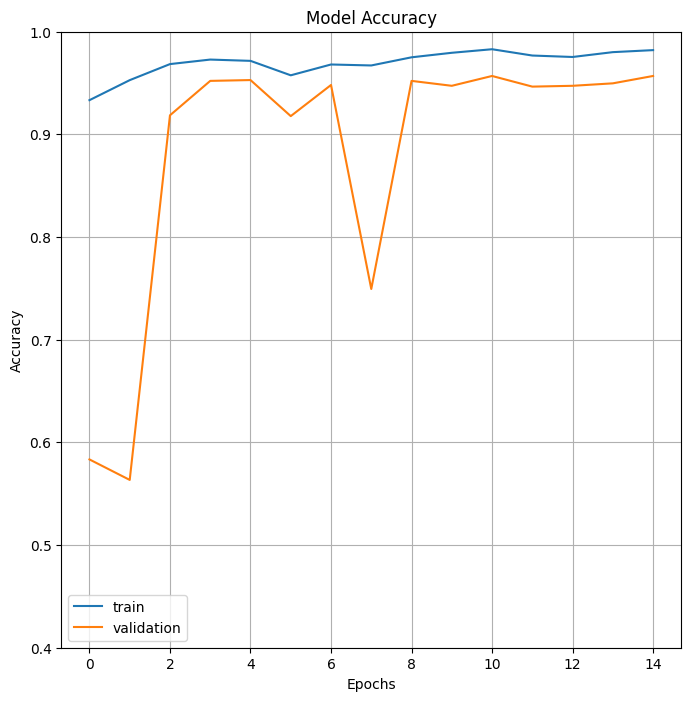

In [ ]:
model1 = MobileNetV2(
    input_shape=(height, width, 3),
    include_top=False,
    weights="imagenet",
)

model1.trainable = True

model = Sequential([
    model1,
    #GlobalAveragePooling2D vs Flatten()
    Flatten(),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate = 3e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/Research - Horizon/Keras models/new_classImbalance_selective_v3_best.keras',
    monitor='val_accuracy',
    save_best_only=True
)

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=45,
    callbacks=[early_stopping, model_checkpoint]
)

model.save("/content/drive/MyDrive/Research - Horizon/Keras models/new_classImbalance_selective_v3.keras")

# Plot data
plt.figure(figsize=(8, 8))
epochs_range = range(len(history.history['accuracy']))
plt.plot(epochs_range, history.history['accuracy'], label="Training Accuracy")
plt.plot(epochs_range, history.history['val_accuracy'], label="Validation Accuracy")
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

#Finding Errors

In [ ]:
#import model
# init model: /content/drive/MyDrive/Research - Horizon/Keras models/new_classImbalance_init_v5_best.keras
# actuall init model: /content/drive/MyDrive/Research - Horizon/Keras models/classImbalance_init_best.keras
model = tf.keras.models.load_model('/content/drive/MyDrive/Research - Horizon/Keras models/classImbalance_init_best.keras')

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96 (Functional)     │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,199,045 (27.46 MB)

 Trainable params: 2,388,225 (9.11 MB)

 Non-trainable params: 34,368 (134.25 KB)

 Optimizer params: 4,776,452 (18.22 MB)

In [ ]:
#predict on the training set since we want to see which ones to dupicate in the data augmentation phase
y_pred = model.predict(train_gen)

822/822 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step


              precision    recall  f1-score   support

           0       0.97      0.94      0.96      6570
           1       0.94      0.97      0.96      6582

    accuracy                           0.96     13152
   macro avg       0.96      0.96      0.96     13152
weighted avg       0.96      0.96      0.96     13152

[35, 117, 118, 119, 129, 130, 131, 168, 169, 186, 187, 188, 196, 228, 229, 230, 240, 241, 249, 251, 261, 262, 263, 264, 265, 266, 269, 277, 304, 312, 313, 314, 324, 325, 328, 329, 333, 334, 335, 345, 346, 347, 380, 387, 389, 392, 420, 421, 422, 456, 457, 458, 468, 469, 470, 486, 488, 489, 490, 491, 517, 525, 526, 527, 632, 687, 779, 784, 786, 792, 793, 794, 801, 802, 803, 806, 897, 898, 899, 1397, 1398, 1400, 1537, 1602, 1620, 1622, 1626, 1627, 1628, 1809, 1810, 1813, 1833, 1924, 1939, 1940, 1952, 1961, 2019, 2020, 2021, 2062, 2063, 2119, 2124, 2125, 2160, 2161, 2162, 2175, 2176, 2177, 2178, 2179, 2180, 2197, 2199, 2202, 2229, 2231, 2263, 2264, 2345, 2349, 2350, 23

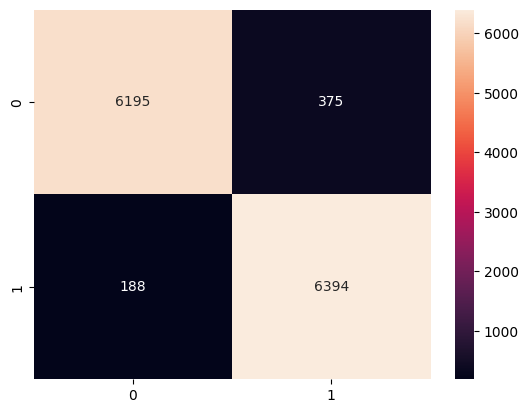

In [ ]:
y_pred = np.round(y_pred)

#classification report
print(classification_report(train_gen.classes, y_pred))

#confusion matrix
cm = confusion_matrix(train_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='g')

#find out which images trick the model
errors = []
for i in range(len(train_gen.classes)):
  if train_gen.classes[i] != y_pred[i]:
    errors.append(i)

print(errors)

In [ ]:
#test accuracy
model2 = tf.keras.models.load_model('/content/drive/MyDrive/Research - Horizon/Keras models/new_classImbalance_selective_v3_best.keras')
y_pred = model2.predict(test_gen)
y_pred = np.round(y_pred)
print(classification_report(test_gen.classes, y_pred))

errors1 = []
for i in range(len(test_gen.classes)):
  if test_gen.classes[i] != y_pred[i]:
    errors1.append(i)

print(errors1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       309
           1       0.94      0.96      0.95       317

    accuracy                           0.95       626
   macro avg       0.95      0.95      0.95       626
weighted avg       0.95      0.95      0.95       626

[16, 21, 82, 96, 98, 100, 120, 148, 150, 152, 157, 196, 223, 234, 237, 242, 264, 274, 290, 306, 361, 379, 420, 472, 483, 490, 498, 516, 561, 593, 594, 607]
